In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import os,datetime
import locale
from IPython.display import HTML
locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=pt_BR.UTF-8;LC_NUMERIC=pt_BR.UTF-8;LC_TIME=pt_BR.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=pt_BR.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=pt_BR.UTF-8;LC_NAME=pt_BR.UTF-8;LC_ADDRESS=pt_BR.UTF-8;LC_TELEPHONE=pt_BR.UTF-8;LC_MEASUREMENT=pt_BR.UTF-8;LC_IDENTIFICATION=pt_BR.UTF-8'

In [2]:
user = os.environ.get('USER_DB_NTFCE')
host = 'localhost'
#        host = '192.168.15.8'
password = os.environ.get('PASS_DB_NTFCE')
banco = 'nota_fiscal'
sql = 'select * from nota_fiscal_produtos_v'
engine = create_engine('mysql://{}:{}@{}/{}'.format(user,password,host, banco), 
                                                    echo = False,
                                                    isolation_level="READ COMMITTED")
conexao = engine.connect()

compras_result_proxy = conexao.execute(sql)
compras_db = compras_result_proxy.fetchall()

#display(compras_result_proxy.keys()) #mostra as colunas
#display(compras_db)

df_compras = pd.DataFrame(compras_db,
                          columns =compras_result_proxy.keys())

df_compras.vl_prod_serv = df_compras.vl_prod_serv.astype(float)
df_compras.vl_pago = df_compras.vl_pago.astype(float)
df_compras.vl_desconto_prod_serv = df_compras.vl_desconto_prod_serv.astype(float)

df_compras['mes_ano_emissao'] =  df_compras.dt_emissao.dt.to_period('M')
#df_compras.columns = compras_result_proxy.keys() #coloca os nomes das colunas
# df_compras.dt_emissao.dt.year
#df_compras.head()
# df_compras.dtypes



In [3]:


def formatar_float(x,decimal=False):
    if decimal:
        return f'{locale.format_string("%.2f", x, True)}'
    else:
        return f'{locale.format_string("%.0f", x, True)}'

ultimos_anos = []
anos = df_compras.dt_emissao.dt.year.unique()
for ano in anos:
    if ano > datetime.datetime.now().year - 3: #pega os ultimos três anos da base, a partir do ano atual
        ultimos_anos.append(ano)




,Quant.,Perc(%)
Valor R$,,
De 0 a R$100,89,63.571429
De R\$ 100 a R$ 200,23,16.428571
De R\$ 200 a R\$ 300,10,7.142857
De R\$ 300 a R\$ 400,6,4.285714
De R\$ 400 a R\$ 500,5,3.571429
De R\$ 500 a R\$ 1000,7,5.000000
De R\$ 1000 a R\$ 10.000,0,0.000000


,Quant.,Perc(%)
Valor R$,,
"[3.26, 125.074)",95,67.857143
"[125.074, 246.888)",24,17.142857
"[246.888, 368.701)",6,4.285714
"[368.701, 490.515)",7,5.000000
"[490.515, 612.329)",2,1.428571
"[612.329, 734.142)",2,1.428571
"[734.142, 855.956)",3,2.142857
"[855.956, 978.745)",1,0.714286


AttributeError: module 'seaborn' has no attribute 'histplot'

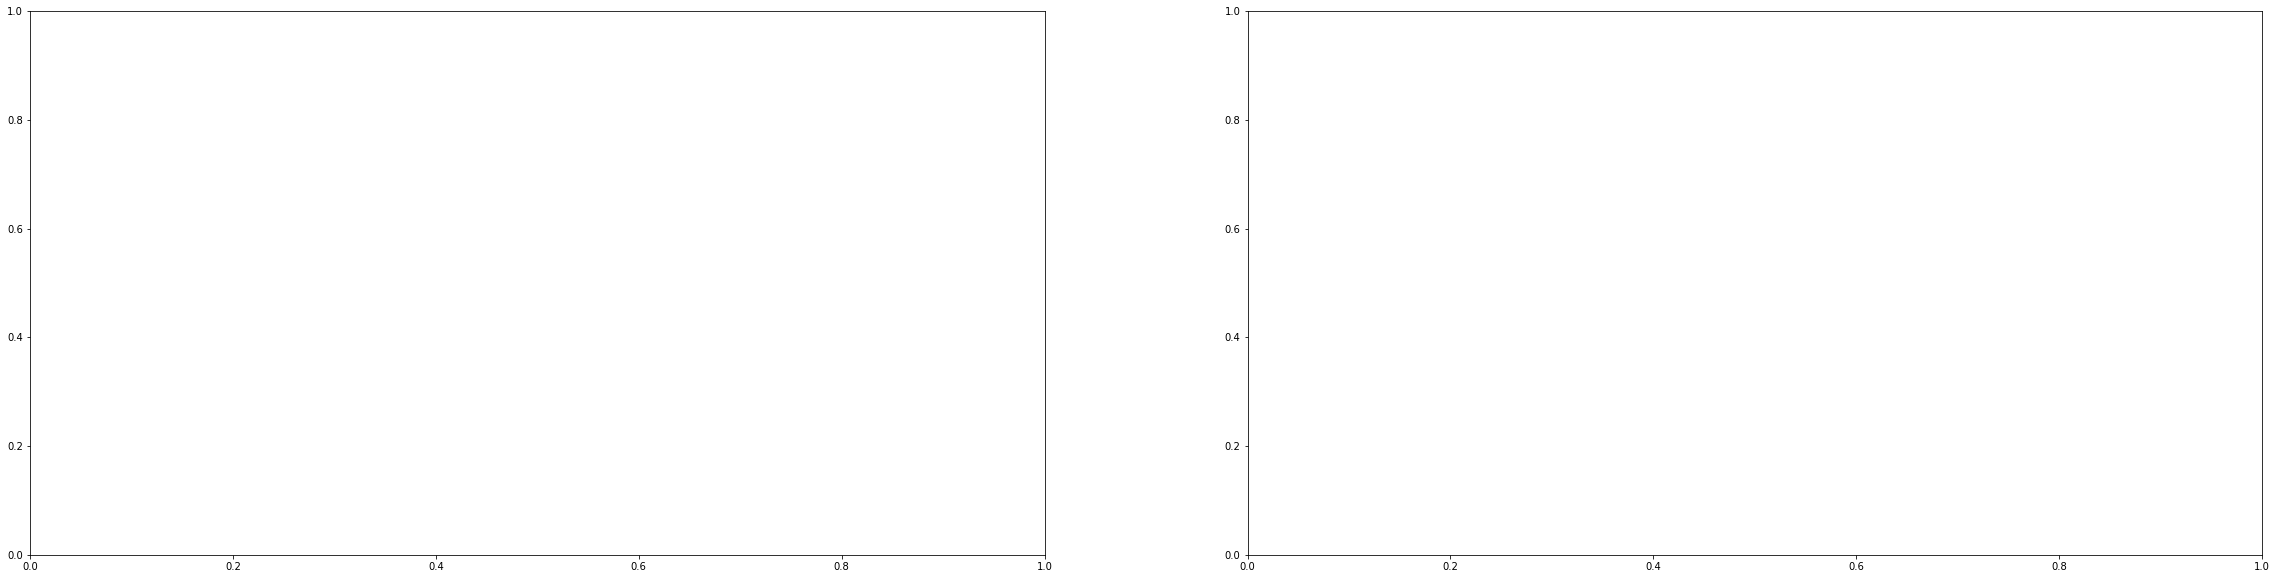

In [4]:
#Distribuição de Frequencia dos valores das compras
fig,ax = plt.subplots(1,2,figsize=(40, 10))

bins = [0,100,200,300,400,500,1000,10000]
labels = ['De 0 a R$100','De R\$ 100 a R$ 200',
          'De R\$ 200 a R\$ 300','De R\$ 300 a R\$ 400',
          'De R\$ 400 a R\$ 500','De R\$ 500 a R\$ 1000',
          'De R\$ 1000 a R\$ 10.000']
for ano in ultimos_anos:
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano].copy()
    
    valor_total = round(df_compras_anual.vl_pago.sum(),2)
    
    display(HTML(f'<h3> Valor Total das Compras em {ano} = {locale.format_string("%.2f", valor_total, True)} </h3>'))
    
    #agrupa pela chave(por nota fiscal)
    df_compras_anual = pd.DataFrame(df_compras_anual.groupby('chave_acesso')['vl_pago'].agg('sum'))
    
    qt_total = df_compras_anual.vl_pago.count()
    display(HTML(f'<h3> Quantidade Total de Compras em {ano} = {locale.format_string("%.0f", qt_total, True)} </h3>'))
    
    ######categoriazando a partir da lista bins usando cut
    cats = pd.cut(df_compras_anual['vl_pago'],
                  bins,
                  labels = labels,
                  right=False) #cria as classes
    
    col_1 = pd.value_counts(cats,
                            sort=False) #conta as classes
    col_2 = pd.value_counts(cats,
                            sort=False,
                            normalize=True) #conta as classes normalizadas
    
    df_ = pd.DataFrame({'Quant.':col_1,'Perc(%)':col_2 * 100})

    df_.index.name = 'Valor R$'
    display(HTML(f'<h4> Quantidade de Compras por Valor </h4>'))
    display(df_) #mostra os dados
    ### fim categorizando cuts
    
    ### categoriazando usando a regra de sturges, classes com amplitude fixas
    num_classes = int(round(1 + (10/3) * np.log10(qt_total),0))
    cats = pd.cut(df_compras_anual['vl_pago'],
                  bins = num_classes,
                  right=False) #cria as classes
    
    col_1 = pd.value_counts(cats,
                            sort=False) #conta as classes
    col_2 = pd.value_counts(cats,
                            sort=False,
                            normalize=True) #conta as classes normalizadas
    
    df_ = pd.DataFrame({'Quant.':col_1,'Perc(%)':col_2 * 100})

    df_.index.name = 'Valor R$'
    display(HTML(f'<h4> Quantidade de Compras por Valor usando Regra Sturges</h4>'))
    display(df_) #mostra os dados
   
    ### fim categorizando regra sturges
    
    
    #Gráficos
    ax1 = sns.histplot(df_compras_anual['vl_pago'],kde=True,ax=ax[1])
    #ax1.figure.set_size_inches(12,10)
    ax1.set_title('Histograma Quant. de Compras',fontsize='18')
    ax1.set_xlabel('Valor da Compra (R$)',fontsize=14)
    ax1.plot()
    
    
    
    cats = pd.cut(df_compras_anual['vl_pago'],
                  bins,
                  right=False) #cria as classes, sem os labels
    df_compras_anual = pd.value_counts(cats,sort=False) #conta as classes
    df_compras_anual = pd.DataFrame(df_compras_anual)
    df_compras_anual.plot(kind='bar',ax=ax[0],rot=0,width=0.8)
    ax[0].set(title=f'Quantidade de Compras - {ano}')
    ax[0].set(yticks=df_compras_anual.values)
    ax[0].grid(axis='y')
    ax[0].set(xlabel='Valor das Compras (R$)')
    
    
    #limpeza
    df_ = col_1 = col_2 = None
    


,Quant,Média,Desv. Pad,Mín,25%,Mediana,75%,Máx
Ano Mês,,,,,,,,
2020-02,4.0,76.042500,76.900413,15.48,37.1100,50.070,89.0025,188.55
2020-03,24.0,106.410000,133.495307,3.26,27.7225,41.715,101.8300,467.77
2020-04,12.0,140.793333,138.748101,22.10,33.8300,90.295,184.7500,454.65
2020-05,17.0,158.615882,209.442657,9.79,24.3700,58.810,219.7800,719.03
2020-06,10.0,213.478000,270.577285,3.60,59.7650,108.620,178.0725,772.09
2020-07,12.0,206.396667,291.022928,12.66,32.6825,61.460,237.2625,977.77
2020-08,16.0,70.890625,75.111169,5.28,24.1575,43.290,81.6525,264.77
2020-09,22.0,150.853182,165.685219,15.11,49.6975,91.780,193.5300,744.96
2020-10,17.0,137.954118,204.607064,7.50,22.4200,59.080,149.4600,819.03


,Ano Mês,Valor
1,2020-02,"304,17"
2,2020-03,"2.553,84"
3,2020-04,"1.689,52"
4,2020-05,"2.696,47"
5,2020-06,"2.134,78"
6,2020-07,"2.476,76"
7,2020-08,"1.134,25"
8,2020-09,"3.318,77"
9,2020-10,"2.345,22"
10,2020-11,"556,18"


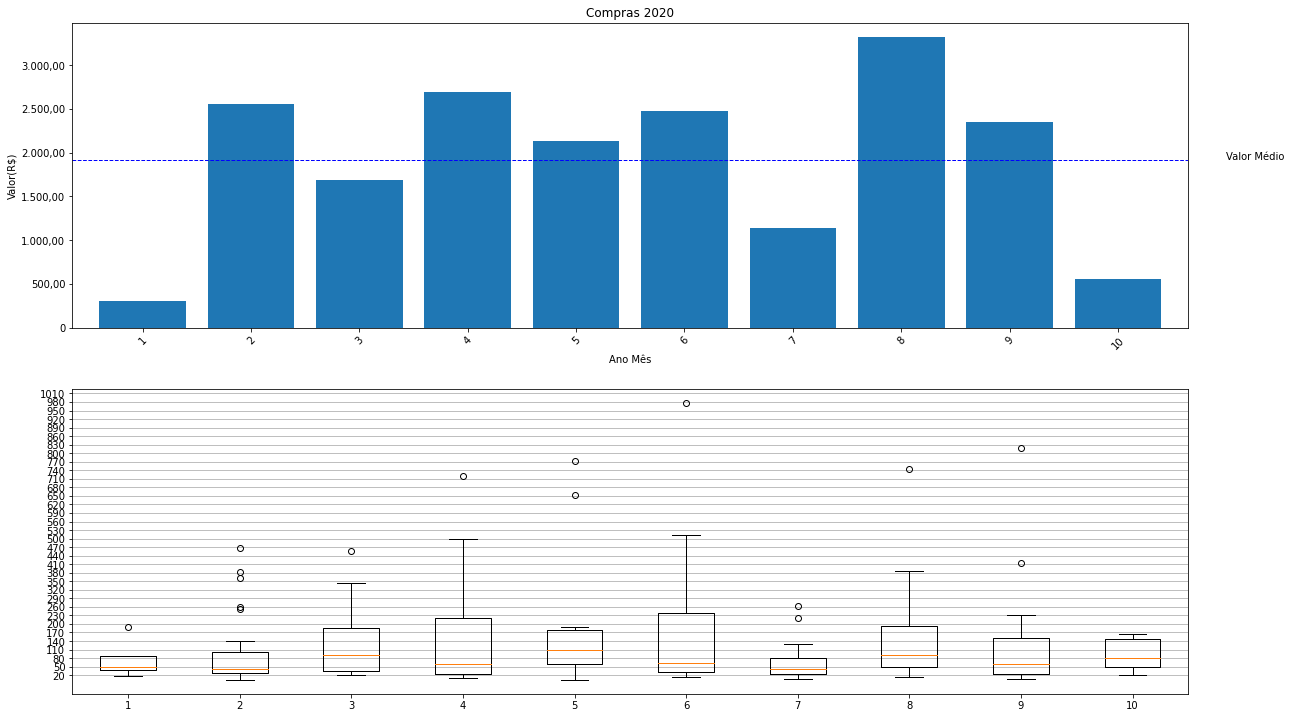

In [5]:
#Valor total mensal das compras por ano

largura = 20
proporcao = 1.62

fig, ax = plt.subplots(2,1,figsize=(largura,largura/proporcao))


for ano in ultimos_anos:
    display(HTML(f'<h3> Compras Mensais - {ano} </h3>'))
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano]
    df_compras_anual = df_compras_anual[['mes_ano_emissao',
                                         'chave_acesso',
                                         'vl_pago']].groupby(by=['mes_ano_emissao','chave_acesso']).sum()
    
    #df_compras_anual.reset_index()
    #display(df_compras_anual.groupby(level=0).describe())
    df = pd.DataFrame(df_compras_anual.groupby(level=0).describe())
    df.columns = ['Quant','Média','Desv. Pad','Mín','25%','Mediana','75%','Máx']
    df.index.name = 'Ano Mês'
    display(df)
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano]
    
                                   
    
    df_compras_anual = pd.DataFrame(df_compras_anual.groupby(['mes_ano_emissao'])['vl_pago'].agg('sum'))
    
    valor_medio = round(df_compras_anual.vl_pago.mean(),2)
    pos_ultimo_mes = df_compras_anual.shape[0]
    
   
    
    
    
    df_compras_anual = df_compras_anual.reset_index()
    df_compras_anual.index += 1
    colunas = df_compras_anual.columns
    df_compras_anual.columns = ['Ano Mês','Valor']
    estilo = {'Valor': lambda x: f'{locale.format_string("%.2f", x, True)}'}
    df_style = df_compras_anual.style.format(estilo) #.style.hide_index()
   
    display(HTML(f'<h4> Valor Total Médio Mensal = R${locale.format_string("%.2f", valor_medio, True)} </h4>'))
    
    display(df_style.background_gradient(cmap='Blues'))
    
    df_compras_anual.columns = colunas
    
    
    #gráfico de barras
    df_compras_anual.plot(kind='bar',y='vl_pago',ax=ax[0],width=0.8)
    formatter = FuncFormatter(formatar_float)
    ax[0].yaxis.set_major_formatter(formatter)
    ax[0].legend().set_visible(False)
    ax[0].set(title=f'Compras {ano}', xlabel='Ano Mês', ylabel='Valor(R$)')
    ax[0].axhline(y=valor_medio, color='b', label='Valor Médio', linestyle='--', linewidth=1)
    ax[0].text(pos_ultimo_mes, valor_medio, "Valor Médio")
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(45)
    
    
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano]
    df_compras_anual = df_compras_anual[['mes_ano_emissao',
                                         'chave_acesso',
                                         'vl_pago']].groupby(by=['mes_ano_emissao','chave_acesso']).sum()
    #box plots
    
    df_compras_anual.reset_index(inplace=True)

    data = []
    xticks = df_compras_anual.mes_ano_emissao.unique()
    for mes_ano in df_compras_anual.mes_ano_emissao.unique():         
         df = df_compras_anual[df_compras_anual.mes_ano_emissao == mes_ano]
         data.append(df['vl_pago'])
        
    ax[1].set(yticks=range(20,int(df_compras_anual.vl_pago.max())+50,30))
    #ax[1].set(xticks=xticks)
    ax[1].grid(axis='y')
    ax[1].boxplot(data)     

nome_empresa,ATACADAO DO PAPEL LTDA,CAFETERIA E BISCOITOS FINOS SOLANGE EIRELI,CENCOSUD BRASIL COMERCIAL LTDA,MASANI COMERCIO DE GENEROS ALIMENTICIOS LTDA,Outros Fornecedores,PETROBRASDISTRIBUIDORASA,R R INDUSTRIACOMERCIO PANIFICACAO LTDA,RAIADROGASIL S.A.,WMB SUPERMERCADOS DO BRASIL LTDA.
mes_ano_emissao,,,,,,,,,
2020-02,"0,00","0,00","0,00","0,00","71,30","188,55","0,00","44,32","0,00"
2020-03,"0,00","99,22","938,47","0,00","866,82","0,00","0,00","34,32","615,01"
2020-04,"0,00","188,19","694,89","0,00","257,90","0,00","93,89","0,00","454,65"
2020-05,"0,00","206,08","695,30","0,00","359,78","0,00","131,19","58,81","1.245,31"
2020-06,"0,00","0,00","30,06","207,30","414,07","0,00","57,40","0,00","1.425,95"
2020-07,"512,80","163,91","186,97","388,14","48,43","0,00","90,96","107,78","977,77"
2020-08,"0,00","165,51","223,12","255,36","27,21","0,00","56,80","141,48","264,77"
2020-09,"0,00","0,00","500,50","568,70","502,45","244,82","93,19","87,66","1.321,45"
2020-10,"0,00","116,12","340,49","373,81","238,22","0,00","22,42","21,48","1.232,68"


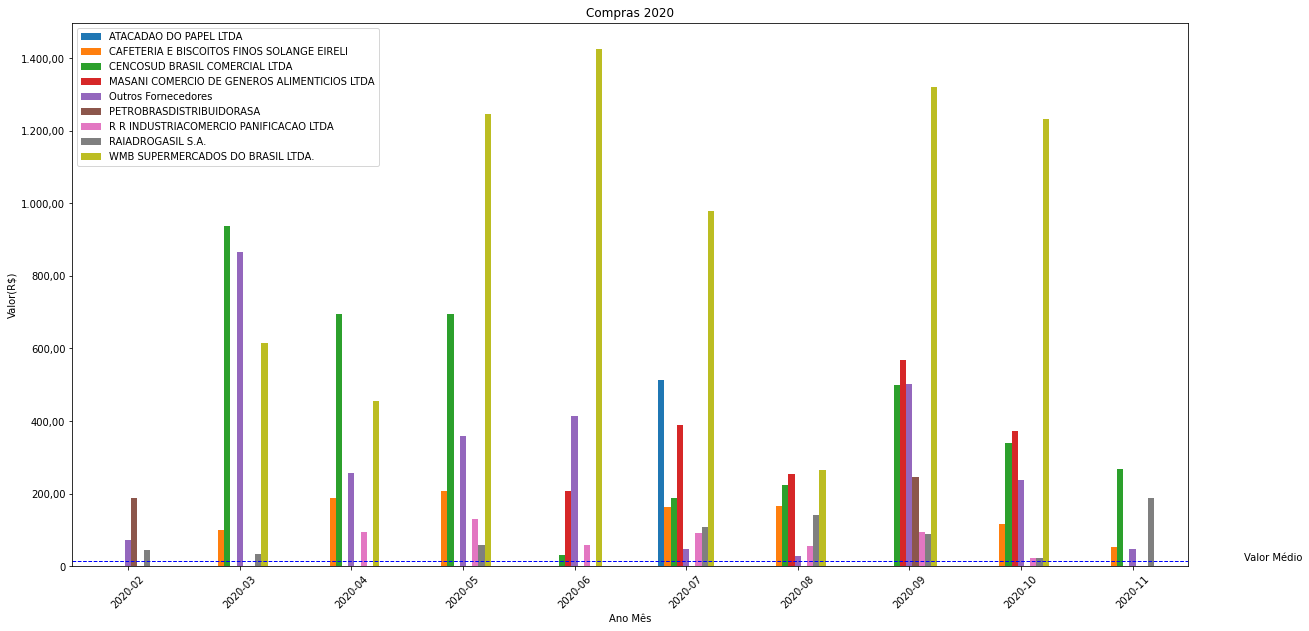

In [6]:
#Valor total mensal por empresa das compras por ano
qt_maiores_empresas = 8    #quantidade máxima de empresas a mostrar, 
fig, ax = plt.subplots(figsize=(20, 10))


for ano in ultimos_anos: #loop nos ultimos anos
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano].copy() #filtra pelo ano
    valor_medio = round(df_compras_anual.vl_pago.mean(),2)
    pos_ultimo_mes = df_compras_anual.mes_ano_emissao.dt.month.unique().shape[0]    
    df_compras_anual = df_compras_anual[['vl_pago']].groupby(df_compras_anual['cnpj']).sum() #agrupa e soma por cnpj
    df_compras_anual.sort_values(by=['vl_pago'], inplace=True,ascending=False)#ordena decres. por soma de vl_pago
    lista_empresas = df_compras_anual.iloc[:qt_maiores_empresas,:0]  #pega as n maiores empresas (cnpj no index)
    df_compras_anual = df_compras[df_compras.dt_emissao.dt.year == ano].copy() #filtra pelo ano
    
    df_compras_anual['nome_empresa'] = df_compras_anual.razao_social    
    df_compras_anual['cnpj_2'] = df_compras_anual.cnpj    
    df_compras_anual.loc[~df_compras_anual.cnpj.isin(lista_empresas.index),'nome_empresa'] = 'Outros Fornecedores' #muda o nome da menores empresas
    df_compras_anual.loc[~df_compras_anual.cnpj.isin(lista_empresas.index),'cnpj_2'] = '99999999999999' #muda o cnpj da menores empresas
    
    df_evolucao = pd.crosstab(df_compras_anual.mes_ano_emissao,
                          df_compras_anual.nome_empresa,
                          values=df_compras_anual.vl_pago,
                          aggfunc='sum').copy()
    df_evolucao.fillna(0,inplace=True) #troca n/a por 0
    
    
    df_evolucao.plot(kind='bar',ax=ax)
    formatter = FuncFormatter(formatar_float)
    ax.yaxis.set_major_formatter(formatter)
    ax.legend().set_visible(True)
    ax.set(title=f'Compras {ano}', xlabel='Ano Mês', ylabel='Valor(R$)')
    ax.axhline(y=valor_medio, color='b', label='Valor Médio', linestyle='--', linewidth=1)
    ax.text(pos_ultimo_mes, valor_medio, "Valor Médio")

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    estilo = {}
    for col in df_evolucao.columns:
        estilo[col] = lambda x: f'{locale.format_string("%.2f", x, True)}'
     
     #estilo = {'Valor': lambda x: f'{locale.format_string("%.2f", x, True)}'}
    df_style = df_evolucao.style.format(estilo) #.style.hide_index()
    display(HTML(f'<h3> Valor Total - Compras Mensais - {ano} </h3>'))
   
    display(df_style.background_gradient(cmap='Blues'))